In [1]:
# import packages needed
import os
import json
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from matplotlib import figure
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mapclassify

# 1. Load the data

## 1.1 London Borough Map

<AxesSubplot:>

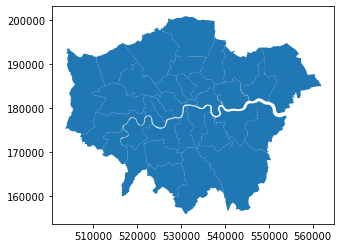

In [2]:
# load the data
boros = gpd.read_file('https://github.com/HaofuW/CASA0013_Mic/blob/main/Assessment3/Code/Boroughs.gpkg?raw=true')
boros.plot()

## 1.2 Inside Airbnb

In [3]:
# load the data and select the columns needed
cols = ['id','name','price','neighbourhood_cleansed','latitude','longitude','property_type','room_type']
url_airbnb = 'http://data.insideairbnb.com/united-kingdom/england/london/2021-10-10/data/listings.csv.gz'
df_airbnb = pd.read_csv(url_airbnb, compression='gzip', usecols=cols)

df_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67903 entries, 0 to 67902
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      67903 non-null  int64  
 1   name                    67879 non-null  object 
 2   neighbourhood_cleansed  67903 non-null  object 
 3   latitude                67903 non-null  float64
 4   longitude               67903 non-null  float64
 5   property_type           67903 non-null  object 
 6   room_type               67903 non-null  object 
 7   price                   67903 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 4.1+ MB


### Data Cleaning

In [4]:
# clean the data
df_airbnb['price'] = df_airbnb.price.str.replace('$','').str.replace(',','').astype(float)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude.isna())|(df_airbnb.longitude.isna()))].index, axis=0, inplace=True)
df_airbnb.drop(df_airbnb[((df_airbnb.latitude < 40)|(df_airbnb.longitude > 1))].index, axis=0, inplace=True)

df_airbnb.info

<ipython-input-4-38418f533085>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_airbnb['price'] = df_airbnb.price.str.replace('$','').str.replace(',','').astype(float)


<bound method DataFrame.info of              id                                               name  \
0         13913                Holiday London DB Room Let-on going   
1         15400                Bright Chelsea  Apartment. Chelsea!   
2         17402              Superb 3-Bed/2 Bath & Wifi: Trendy W1   
3         17506  Boutique Chelsea/Fulham Double bed 5-star ensuite   
4         24328  Battersea bedroom & studio, parking, shared ga...   
...         ...                                                ...   
67898  52708661                          Immaculate room available   
67899  52710377      Double studio apartment in Lancaster Gate (14   
67900  52711482  4 Bedroom House in The Tonsleys (Wandsworth Town)   
67901  52712635                           Faveo Dartford Apartment   
67902  52717191                       Double bedroom in 2-bed flat   

       neighbourhood_cleansed   latitude  longitude  \
0                   Islington  51.568610  -0.112700   
1      Kensington

In [5]:
# focus on "Private room" in the room type
ab_room_type = 'Private room'
df_airbnb = df_airbnb[df_airbnb.room_type == ab_room_type]

## 1.3 Rental

In [6]:
# load the data and select the columns needed
cols_rental = ['Borough','Bedroom_Category','Count_of_rents','Mean']
url_rental = 'https://github.com/HaofuW/CASA0013_Mic/blob/main/Assessment3/Code/london_rental_statistics.xlsx?raw=true'
df_rental = pd.read_excel(url_rental, sheet_name = 0, usecols = cols_rental)

df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Borough           198 non-null    object 
 1   Bedroom_Category  198 non-null    object 
 2   Count_of_rents    188 non-null    float64
 3   Mean              188 non-null    float64
dtypes: float64(2), object(2)
memory usage: 6.3+ KB


In [7]:
df_rental.sample(3, random_state=42)

,Borough,Bedroom_Category,Count_of_rents,Mean
65,Greenwich,Four or More Bedrooms,50.0,2079.0
114,Kensington and Chelsea,Room,NaN,NaN
16,Bexley,Three Bedrooms,200.0,1294.0


### Data Cleaning

In [8]:
# clean the data
df_rental.drop(index = df_rental[df_rental.Count_of_rents.isna()].index, axis=0, inplace=True)
df_rental.drop(index = df_rental[df_rental.Mean.isna()].index, axis = 0, inplace=True)

print(df_rental.shape)
df_rental.sample(3, random_state=42)

(188, 4)


,Borough,Bedroom_Category,Count_of_rents,Mean
193,Westminster,Studio,220.0,1315.0
171,Sutton,Two Bedrooms,560.0,1171.0
19,Brent,Studio,120.0,904.0


In [9]:
# focus on "Room" in the rental market
rental_room_type = 'Room'
df_rental = df_rental[df_rental.Bedroom_Category == rental_room_type]

# 2. Basic Analysis

## 2.1 Counts of Private Room in Airbnb Listings

In [10]:
# set the data in one group
airbnb_data = df_airbnb.groupby(['neighbourhood_cleansed'])
print(type(airbnb_data))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [11]:
# count the listings in each borough
count_series = airbnb_data.neighbourhood_cleansed.apply(pd.value_counts)
count_boros = pd.Series(count_series ,name='count')
count_boros

neighbourhood_cleansed                        
Barking and Dagenham    Barking and Dagenham       253
Barnet                  Barnet                     824
Bexley                  Bexley                     181
Brent                   Brent                      940
Bromley                 Bromley                    310
Camden                  Camden                    1616
City of London          City of London              55
Croydon                 Croydon                    643
Ealing                  Ealing                     915
Enfield                 Enfield                    356
Greenwich               Greenwich                  754
Hackney                 Hackney                   2230
Hammersmith and Fulham  Hammersmith and Fulham    1070
Haringey                Haringey                  1002
Harrow                  Harrow                     262
Havering                Havering                   142
Hillingdon              Hillingdon                 379
Hounslow          

### Histogram of Counts

<AxesSubplot:xlabel='neighbourhood_cleansed', ylabel='count'>

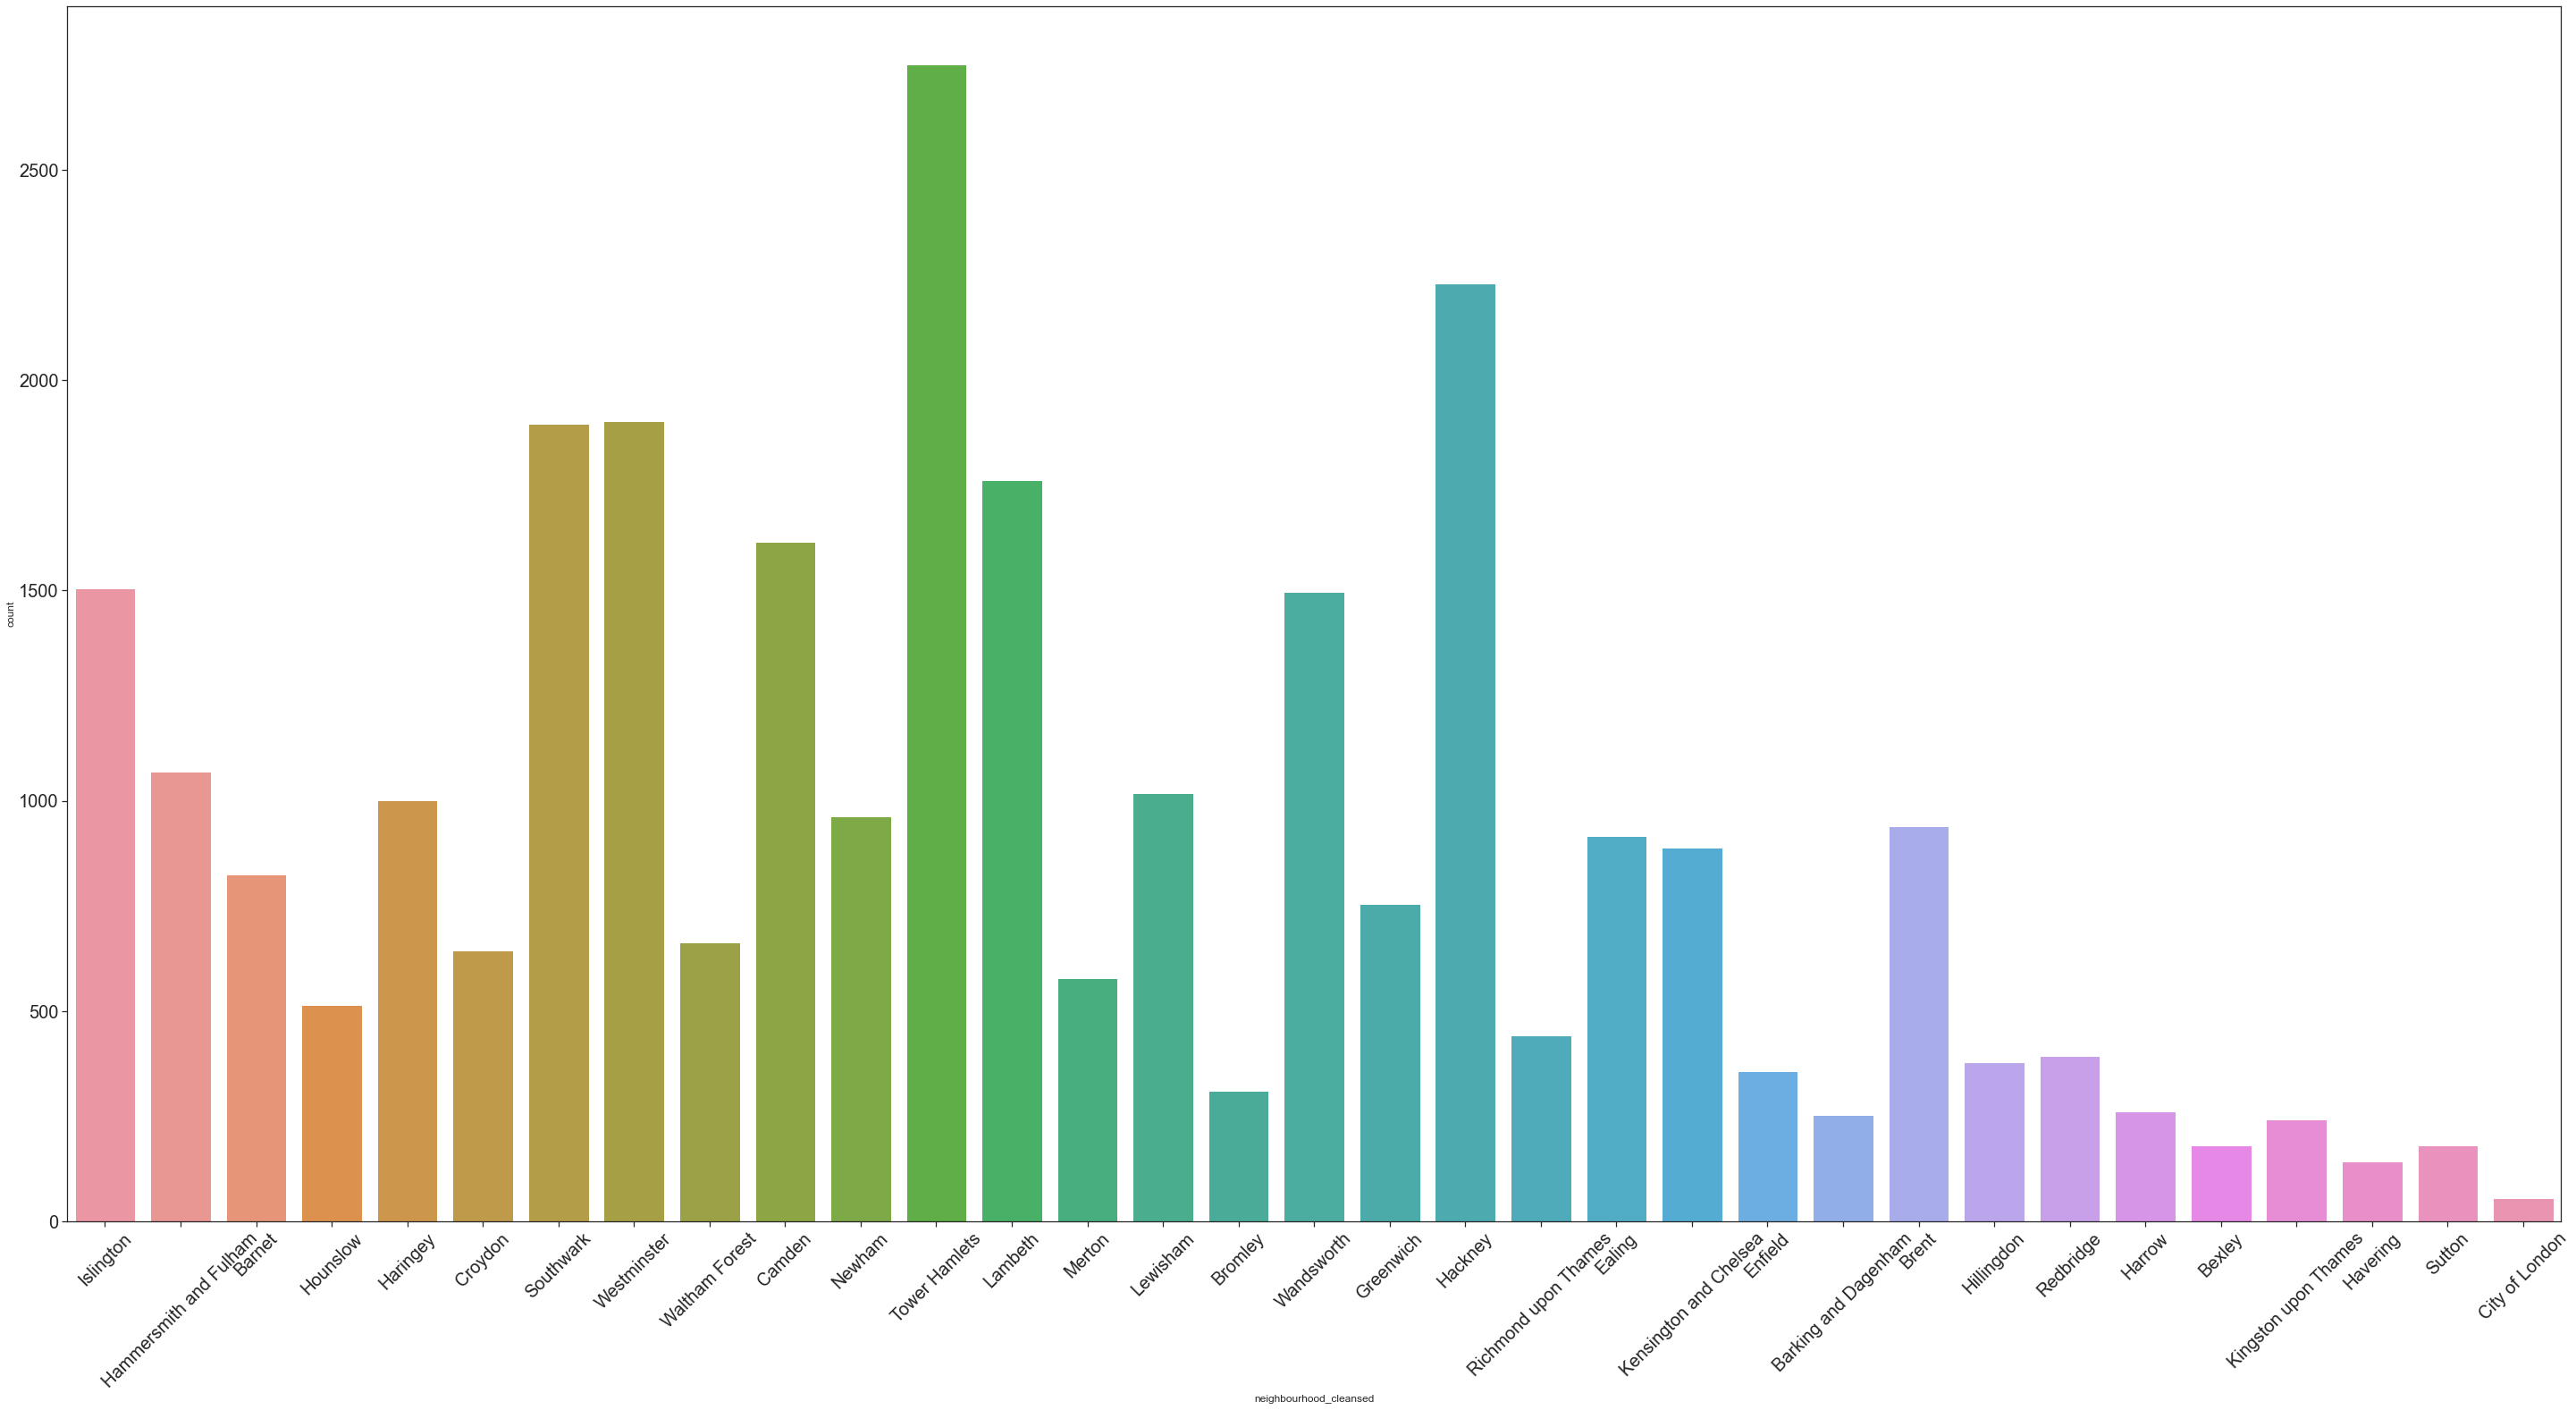

In [12]:
# plot the counts of listings in each borough
sns.set_style('whitegrid')
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(50, 25))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.xticks(rotation=45)

sns.countplot(x="neighbourhood_cleansed", data = df_airbnb)

# 3. Mapping

## 3.1 Private Room of Airbnb Distributions

### Add Geometry and Reproject

In [13]:
# Convert the df into a GeoDataFrame named gdf
gdf_airbnb = gpd.GeoDataFrame(df_airbnb, geometry=gpd.points_from_xy(df_airbnb.longitude, df_airbnb.latitude, crs='epsg:4326'))
gdf_airbnb = gdf_airbnb.to_crs('epsg:27700')

### Add LA Names to Data

In [14]:
# Associate LA (Local Authority) names to the listings using a spatial join
gdf_boros = gpd.sjoin(gdf_airbnb, boros, op='within', how='left')
print(gdf_boros.columns.values)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


['id' 'name' 'neighbourhood_cleansed' 'latitude' 'longitude'
 'property_type' 'room_type' 'price' 'geometry' 'index_right' 'NAME'
 'GSS_CODE' 'HECTARES' 'NONLD_AREA' 'ONS_INNER']


In [15]:
print(gdf_boros.shape)
gdf_boros.sample(3, random_state=42)[['id','name','NAME']]

(29127, 15)


,id,name,NAME
38329,30553269,Cosy Double Room Close To Central London,Tower Hamlets
12927,12613250,Lovely room on right in 1825 house,Islington
13543,13130953,Great location & views-18 Floor-Bedroom & Bath...,Tower Hamlets


### Tidy Up

In [16]:
gdf_boros.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)
gdf_boros.NAME.unique()

array(['Islington', 'Hammersmith and Fulham', 'Barnet', 'Hounslow',
       'Haringey', 'Croydon', 'Southwark', 'Westminster',
       'Waltham Forest', 'Camden', 'Newham', 'Tower Hamlets', 'Lambeth',
       'Merton', 'Lewisham', 'Bromley', 'Wandsworth', 'Greenwich',
       'Hackney', 'Richmond upon Thames', 'Ealing',
       'Kensington and Chelsea', 'Enfield', 'Barking and Dagenham',
       'Brent', 'Hillingdon', 'Redbridge', 'Harrow', 'Bexley',
       'Kingston upon Thames', 'Havering', 'Sutton', 'City of London',
       nan], dtype=object)

In [17]:
gdf_airbnb[gdf_boros.NAME.isna()][['id','name']]

,id,name
66840,52240064,GR-2 a double Room with - En-suite
67014,52320959,"Warm family home, a place for families on the go!"
67441,52513179,2 Bedroom Luxury Riverside Apartment
67591,52577592,Cosy double room for 1.


In [18]:
# drop problematic results
gdf_boros.drop(index=gdf_airbnb[gdf_boros.NAME.isna()].index, axis=1, inplace=True)
print(gdf_boros.shape)

(29123, 11)


### Check Results

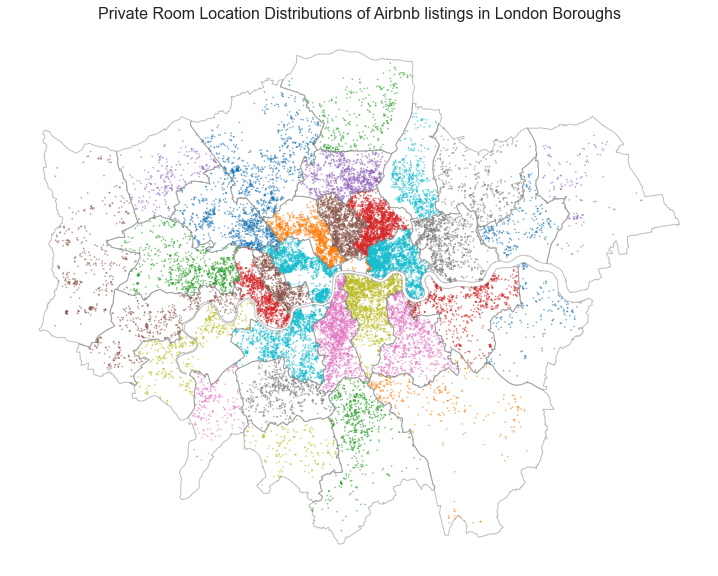

In [19]:
# plot the locations of airbnb listings
def map_airbnb_loc():
    
    ax = gdf_boros.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(16,10))
    boros.plot(ax=ax, edgecolor='0.5', facecolor='None', alpha=0.5);
    ax.axis('off')

    ax.set_title('Private Room Location Distributions of Airbnb listings in London Boroughs', fontdict={
             'fontsize': '16', 'fontweight': '1'})
    
map_airbnb_loc()

### Plot the Counts of Private Room in Airbnb Listings

In [20]:
# merge the data
boros_airbnb_count = pd.merge(boros, count_boros, left_on = 'NAME', right_on = 'neighbourhood_cleansed', how = 'inner')
boros_airbnb_count.sample(3, random_state=42)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,count
31,Barking and Dagenham,E09000002,3779.934,169.150,F,"MULTIPOLYGON (((543905.400 183199.100, 543905....",253
15,Enfield,E09000010,8220.025,0.000,F,"MULTIPOLYGON (((531023.500 200933.600, 531039....",356
26,Tower Hamlets,E09000030,2157.501,179.707,T,"MULTIPOLYGON (((533387.600 180516.400, 533389....",2752


In [21]:
boros_airbnb_count.drop(columns=['HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

<ipython-input-22-f5e79ceb7ca0>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels(bins)


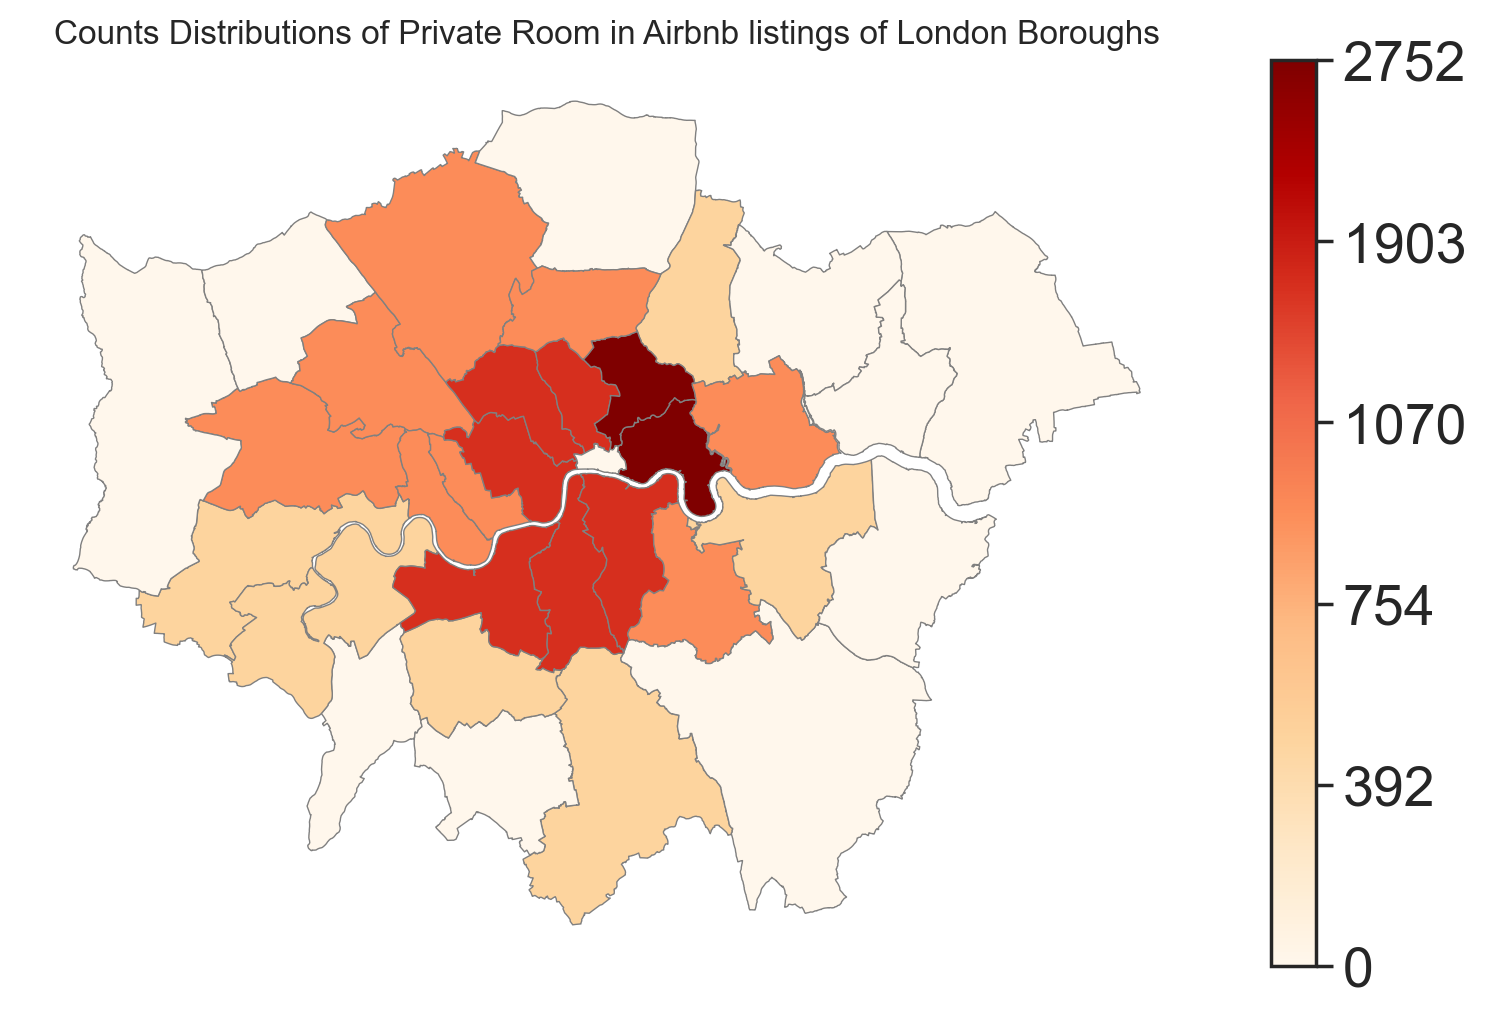

In [22]:
def map_airbnb_counts():
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)

    boros_airbnb_count.plot(column='count', cmap='OrRd', scheme='FisherJenks',
                            linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='OrRd')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(boros_airbnb_count['count'], 5).bins
    bins = np.insert(bins, 0, 0)
    _ = cbar.ax.set_yticklabels(bins)
    
    ax.set_title('Counts Distributions of Private Room in Airbnb listings of London Boroughs', fontdict={
             'fontsize': '12', 'fontweight': '1'})
    
map_airbnb_counts()

## 3.2 Average price of Private Room of Airbnb

In [23]:
# set the data in one group
gdf_data = gdf_boros.groupby(['NAME'])
print(type(gdf_data))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [24]:
# calculate the mean price of airbnb by borough
airbnb_price_mean = gdf_data.price.mean()
airbnb_price_mean

NAME
Barking and Dagenham       55.521739
Barnet                    130.667476
Bexley                     39.171271
Brent                      68.807447
Bromley                    56.880645
Camden                     90.356436
City of London            123.127273
Croydon                    53.323484
Ealing                     63.318033
Enfield                    47.558989
Greenwich                  85.680851
Hackney                    67.064574
Hammersmith and Fulham     72.160898
Haringey                   68.730539
Harrow                     45.706107
Havering                   40.901408
Hillingdon                 80.513228
Hounslow                   82.233010
Islington                 114.821262
Kensington and Chelsea     88.519685
Kingston upon Thames       73.095436
Lambeth                    52.351106
Lewisham                   49.797841
Merton                     69.339100
Newham                     54.923077
Redbridge                  55.790816
Richmond upon Thames       67.664

In [25]:
# merge the data
boros_airbnb_price = boros.merge(airbnb_price_mean, how = 'left', on = 'NAME')
boros_airbnb_price.sample(3, random_state=42)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,price
31,Barking and Dagenham,E09000002,3779.934,169.150,F,"MULTIPOLYGON (((543905.400 183199.100, 543905....",55.521739
15,Enfield,E09000010,8220.025,0.000,F,"MULTIPOLYGON (((531023.500 200933.600, 531039....",47.558989
26,Tower Hamlets,E09000030,2157.501,179.707,T,"MULTIPOLYGON (((533387.600 180516.400, 533389....",60.884811


In [26]:
# tidy up
boros_airbnb_price.drop(columns=['HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

<ipython-input-55-51cda8226b69>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels(bins)


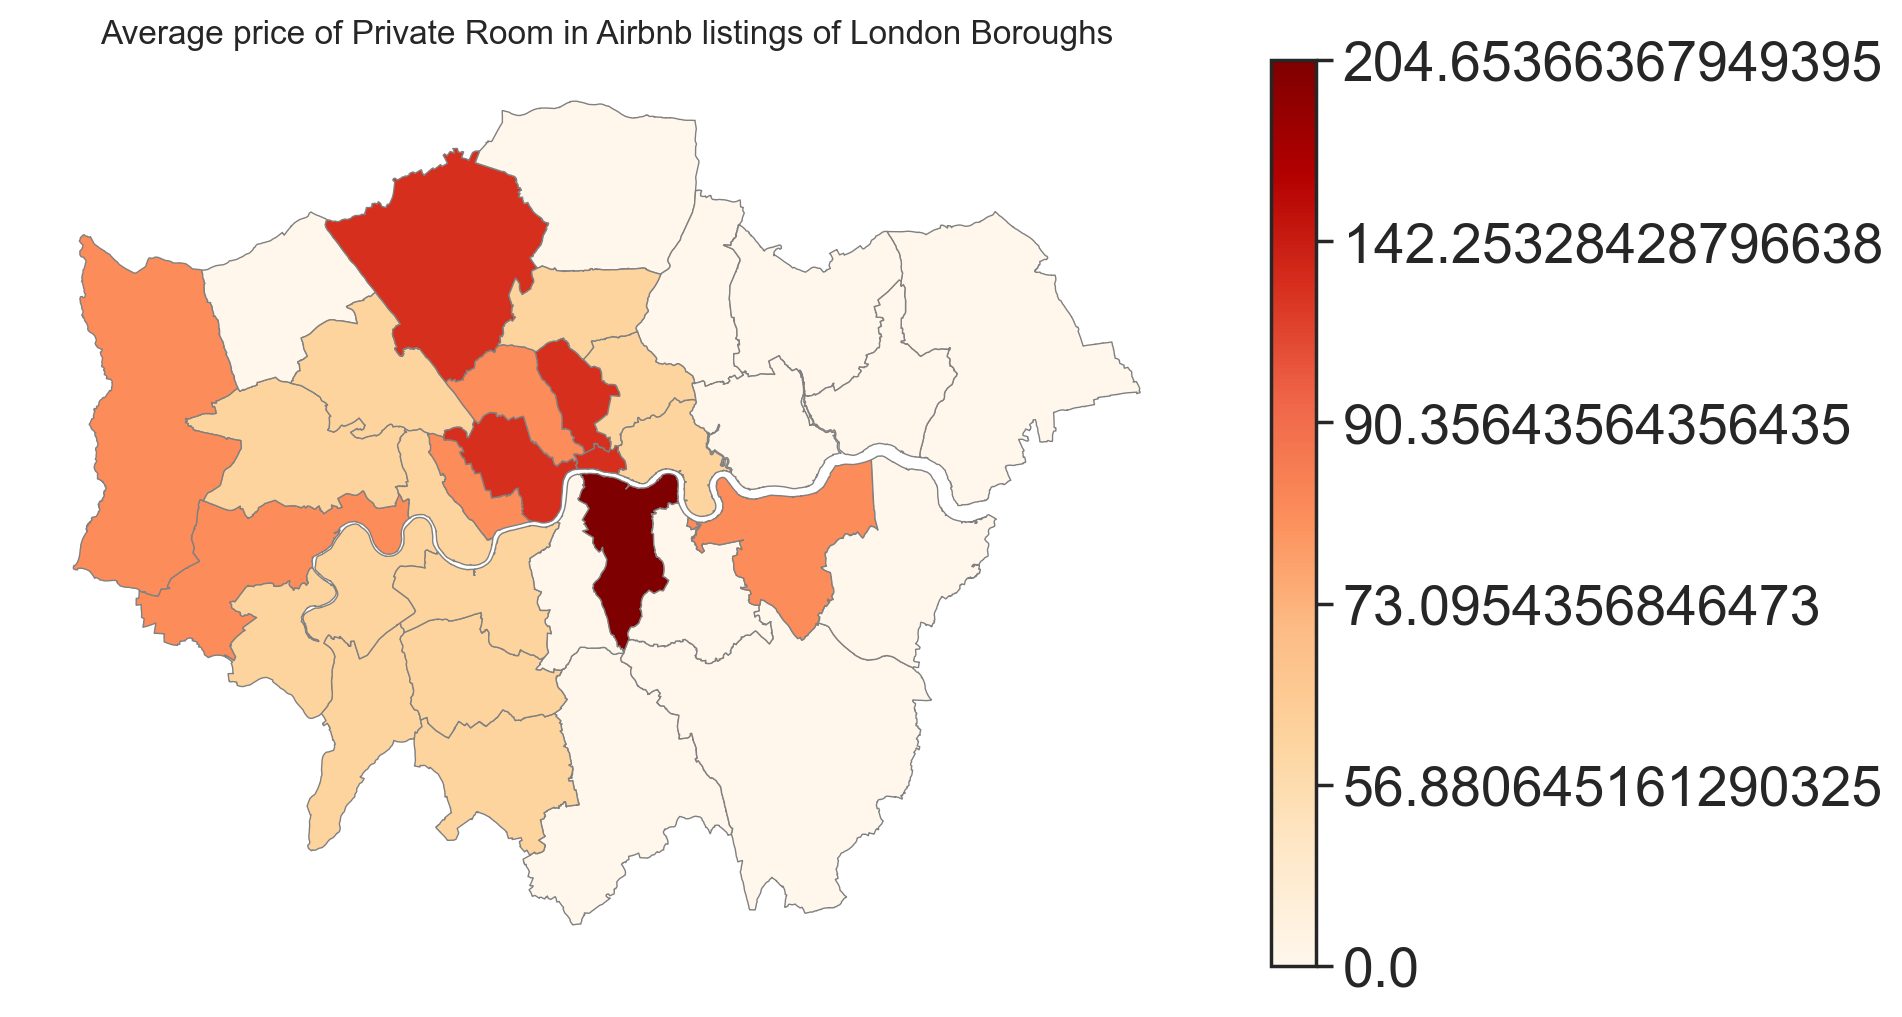

In [55]:
def map_airbnb_price():
    
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)
    
    boros_airbnb_price.plot(column='price', cmap='OrRd', scheme='FisherJenks',
                            linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='OrRd')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(boros_airbnb_price['price'], 5).bins
    bins = np.insert(bins, 0, 0)
    _ = cbar.ax.set_yticklabels(bins)

    ax.set_title('Average price of Private Room in Airbnb listings of London Boroughs', fontdict={
        'fontsize': '12', 'fontweight': '1'})
    
map_airbnb_price()

## 3.3 Average price of Single Room in Rental Market

In [28]:
# merge the data
boros_rental = pd.merge(boros, df_rental, left_on = 'NAME', right_on = 'Borough', how = 'inner')
boros_rental.sample(3, random_state=42)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,Borough,Bedroom_Category,Count_of_rents,Mean
8,Brent,E09000005,4323.270,0.0,F,"MULTIPOLYGON (((525201.000 182512.600, 525181....",Brent,Room,60.0,621.0
16,Sutton,E09000029,4384.698,0.0,F,"MULTIPOLYGON (((528552.300 159658.100, 528399....",Sutton,Room,10.0,605.0
0,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((516401.600 160201.800, 516407....",Kingston upon Thames,Room,110.0,506.0


In [29]:
# tidy up
boros_rental.drop(columns=['HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

<ipython-input-30-ceba74e91261>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  legend = cbar.ax.set_yticklabels(bins)


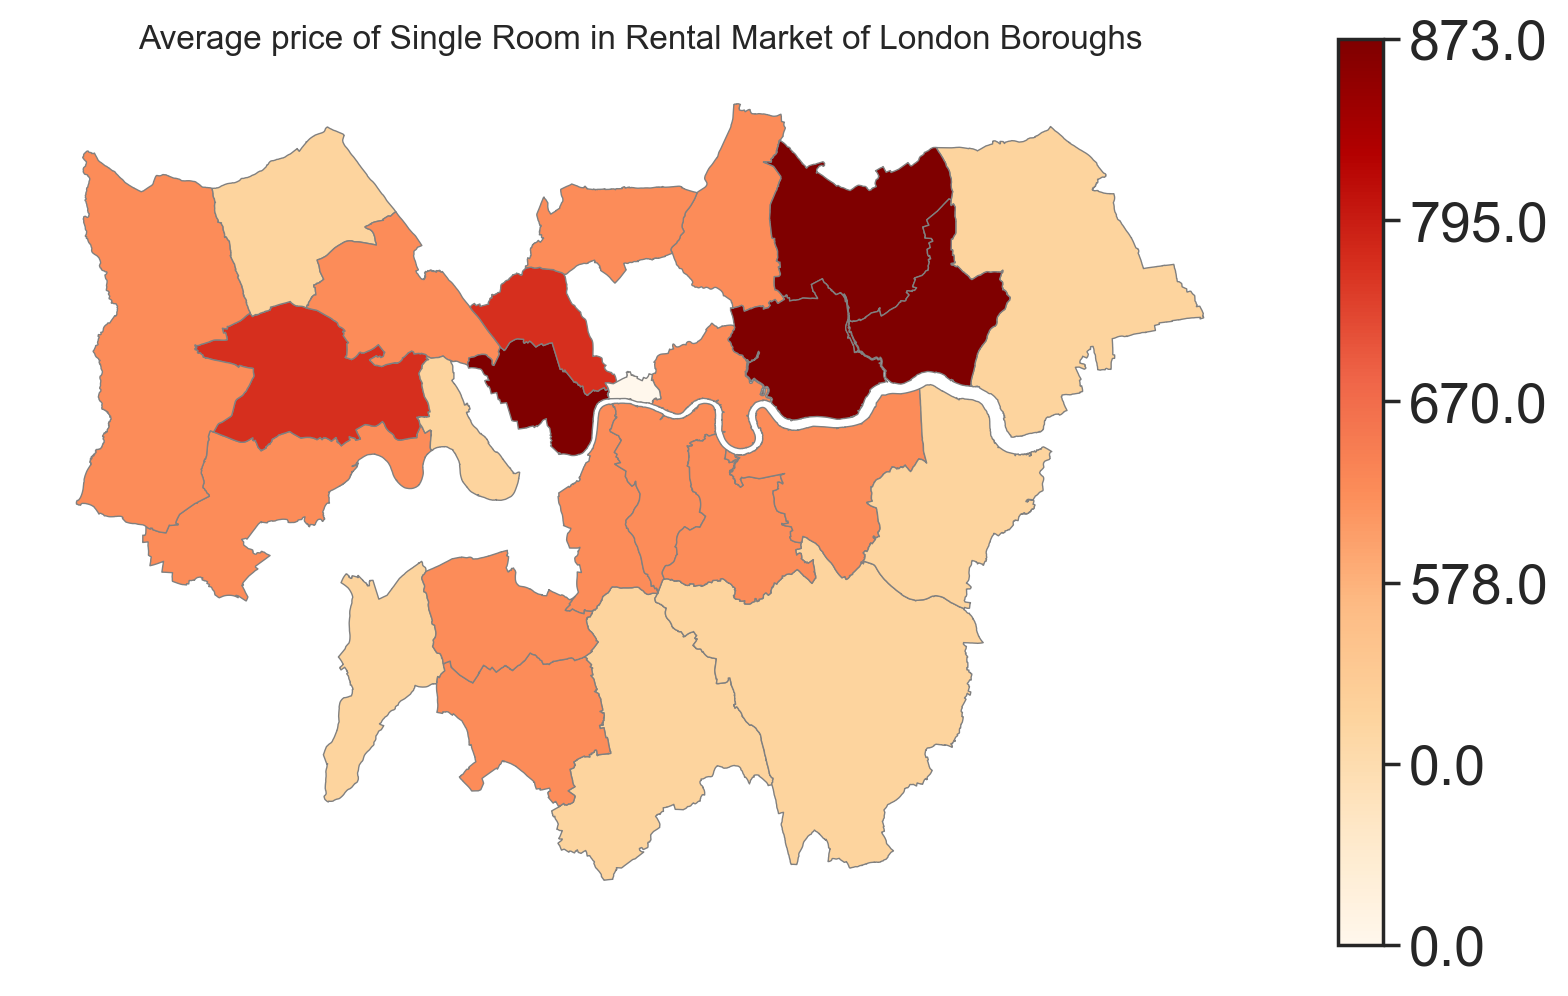

In [30]:
def map_rental_price():
    
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)

    boros_rental.plot(column='Mean', cmap='OrRd', scheme='FisherJenks',
                      linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='OrRd')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(boros_rental['Mean'], 5).bins
    bins = np.insert(bins, 0, 0)
    legend = cbar.ax.set_yticklabels(bins)

    ax.set_title('Average price of Single Room in Rental Market of London Boroughs', fontdict={
        'fontsize': '12', 'fontweight': '1'})
    
map_rental_price()

# 4. Regression

## 4.1 Average Price of Single Room in Rental Market & Counts of Private Room in Airbnb Listings

In [31]:
# merge the data of rental and airbnb counts
boros_rental_airbnb_count = boros_rental.merge(boros_airbnb_count, how = 'left', on = 'NAME')
boros_rental_airbnb_count.sample(3, random_state=42)

,NAME,GSS_CODE_x,geometry_x,Borough,Bedroom_Category,Count_of_rents,Mean,GSS_CODE_y,geometry_y,count
8,Brent,E09000005,"MULTIPOLYGON (((525201.000 182512.600, 525181....",Brent,Room,60.0,621.0,E09000005,"MULTIPOLYGON (((525201.000 182512.600, 525181....",940
16,Sutton,E09000029,"MULTIPOLYGON (((528552.300 159658.100, 528399....",Sutton,Room,10.0,605.0,E09000029,"MULTIPOLYGON (((528552.300 159658.100, 528399....",180
0,Kingston upon Thames,E09000021,"MULTIPOLYGON (((516401.600 160201.800, 516407....",Kingston upon Thames,Room,110.0,506.0,E09000021,"MULTIPOLYGON (((516401.600 160201.800, 516407....",241


### Linear Regression

In [32]:
# set the average price of airbnb as x value
# set the average price of rental market as y value
x_values = boros_rental_airbnb_count['count']
y_values = boros_rental_airbnb_count['Mean']

In [33]:
x_values

0      241
1      643
2      310
3      515
4      915
5      142
6      379
7      262
8      940
9     1763
10    1897
11    1019
12     754
13     181
14     662
15     392
16     180
17     578
18    1070
19    1903
20    1616
21    2752
22    1002
23     962
24     253
25      55
Name: count, dtype: int64

In [34]:
y_values

0     506.0
1     546.0
2     549.0
3     602.0
4     778.0
5     578.0
6     585.0
7     531.0
8     621.0
9     668.0
10    670.0
11    615.0
12    626.0
13    495.0
14    619.0
15    873.0
16    605.0
17    632.0
18    548.0
19    865.0
20    795.0
21    650.0
22    617.0
23    844.0
24    859.0
25      0.0
Name: Mean, dtype: float64

In [35]:
import statsmodels.api as sms

X_values = sms.add_constant(x_values)
regression_model_a = sms.OLS(y_values, X_values)
regression_model_b = regression_model_a.fit()

print(regression_model_b.summary())
print()

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     4.224
Date:                Mon, 10 Jan 2022   Prob (F-statistic):             0.0509
Time:                        22:08:29   Log-Likelihood:                -167.98
No. Observations:                  26   AIC:                             340.0
Df Residuals:                      24   BIC:                             342.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        545.5714     50.305     10.845      0.0

In [36]:
p_value    = regression_model_b.f_pvalue
R_squared  = regression_model_b.rsquared
print("R_squared  =", R_squared)
print("p_value    =", p_value)

R_squared  = 0.1496562663817228
p_value    = 0.05089733459055718


### Linear Regression after Logarithm

In [37]:
import statsmodels.formula.api as sm

regression_model_log = sm.ols(formula="Mean ~ count.apply(np.log)", data = boros_rental_airbnb_count).fit()
print(regression_model_log.params)

Intercept              -48.840348
count.apply(np.log)    106.341703
dtype: float64


In [38]:
print(regression_model_log.summary())

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     12.69
Date:                Mon, 10 Jan 2022   Prob (F-statistic):            0.00158
Time:                        22:08:29   Log-Likelihood:                -164.57
No. Observations:                  26   AIC:                             333.1
Df Residuals:                      24   BIC:                             335.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -48.8403    

In [39]:
p_value_log    = regression_model_log.f_pvalue
R_squared_log  = regression_model_log.rsquared
print("R_squared_log  =", R_squared_log)
print("p_value_log    =", p_value_log)

R_squared_log  = 0.3458879983867592
p_value_log    = 0.0015782567631372566


## 4.2 Average Price of Single Room in Rental Market & Average Price of Private Room in Airbnb Listings

In [40]:
# merge the data of rental and airbnb
boros_rental_airbnb_price_outlier = pd.merge(boros_rental, airbnb_price_mean, left_on = 'Borough', right_on = 'NAME', how = 'inner')
boros_rental_airbnb_price_outlier.sample(3, random_state=42)

,NAME,GSS_CODE,geometry,Borough,Bedroom_Category,Count_of_rents,Mean,price
8,Brent,E09000005,"MULTIPOLYGON (((525201.000 182512.600, 525181....",Brent,Room,60.0,621.0,68.807447
16,Sutton,E09000029,"MULTIPOLYGON (((528552.300 159658.100, 528399....",Sutton,Room,10.0,605.0,72.055556
0,Kingston upon Thames,E09000021,"MULTIPOLYGON (((516401.600 160201.800, 516407....",Kingston upon Thames,Room,110.0,506.0,73.095436


### Clean the Outliers

In [41]:
outlier_test = boros_rental_airbnb_price_outlier.copy()

In [42]:
upper_limit_y = outlier_test['Mean'].quantile(0.995)
lower_limit_y = outlier_test['Mean'].quantile(0.005)

In [43]:
outlier_data_y = outlier_test[(outlier_test['Mean']<upper_limit_y)&(outlier_test['Mean']>lower_limit_y)]

In [44]:
upper_limit_x = outlier_data_y['price'].quantile(0.995)
lower_limit_x = outlier_data_y['price'].quantile(0.005)

In [45]:
boros_rental_airbnb_price=outlier_data_y[(outlier_data_y['price']<upper_limit_x)&(outlier_data_y['price']>lower_limit_x)]

In [46]:
boros_rental_airbnb_price.sample(3, random_state=42)

,NAME,GSS_CODE,geometry,Borough,Bedroom_Category,Count_of_rents,Mean,price
0,Kingston upon Thames,E09000021,"MULTIPOLYGON (((516401.600 160201.800, 516407....",Kingston upon Thames,Room,110.0,506.0,73.095436
16,Sutton,E09000029,"MULTIPOLYGON (((528552.300 159658.100, 528399....",Sutton,Room,10.0,605.0,72.055556
8,Brent,E09000005,"MULTIPOLYGON (((525201.000 182512.600, 525181....",Brent,Room,60.0,621.0,68.807447


### Linear Regression

In [47]:
# set the average price of airbnb as x value
# set the average price of rental market as y value
x_values = boros_rental_airbnb_price['price']
y_values = boros_rental_airbnb_price['Mean']

In [48]:
x_values

0      73.095436
1      53.323484
2      56.880645
3      82.233010
4      63.318033
5      40.901408
6      80.513228
7      45.706107
8      68.807447
9      52.351106
11     49.797841
12     85.680851
14     45.225076
16     72.055556
17     69.339100
18     72.160898
19    142.253284
20     90.356436
21     60.884811
22     68.730539
23     54.923077
24     55.521739
Name: price, dtype: float64

In [49]:
y_values

0     506.0
1     546.0
2     549.0
3     602.0
4     778.0
5     578.0
6     585.0
7     531.0
8     621.0
9     668.0
11    615.0
12    626.0
14    619.0
16    605.0
17    632.0
18    548.0
19    865.0
20    795.0
21    650.0
22    617.0
23    844.0
24    859.0
Name: Mean, dtype: float64

In [50]:
X_values = sms.add_constant(x_values)
regression_model_a = sms.OLS(y_values, X_values)
regression_model_b = regression_model_a.fit()

print(regression_model_b.summary())
print()

                            OLS Regression Results                            
Dep. Variable:                   Mean   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     3.206
Date:                Mon, 10 Jan 2022   Prob (F-statistic):             0.0885
Time:                        22:08:30   Log-Likelihood:                -132.31
No. Observations:                  22   AIC:                             268.6
Df Residuals:                      20   BIC:                             270.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        520.5763     74.114      7.024      0.0

In [51]:
p_value    = regression_model_b.f_pvalue
R_squared  = regression_model_b.rsquared
print("R_squared  =", R_squared)
print("p_value    =", p_value)

R_squared  = 0.13816527749480156
p_value    = 0.08850481146943741
